In [24]:
# Select LLM for RAG
#model_select= "llama3.1" # ollama models: "llama3:70B","llama3.1" open AI models: "gpt-4o","gpt-4o-mini"

# Set up enviroment and functions

import os
import glob
import rdflib
import concurrent.futures

# Define a function to read and parse a single JSON-LD file into an RDFLib graph
def read_and_parse_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()
        graph = rdflib.Graph()
        graph.parse(data=file_content, format='json-ld')
    return graph

# Define a function to load JSON-LD files into an RDFLib graph using concurrent processing
def load_jsonld_files_to_graph(folder_path):
    # Get all JSON-LD files in the specified folder
    jsonld_files = glob.glob(os.path.join(folder_path, "*.json"))

    # Create an empty RDFLib graph
    graph = rdflib.Graph()

    # Use concurrent processing to read and parse files in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map the read_and_parse_file function to each file path
        results = executor.map(read_and_parse_file, jsonld_files)

    # Combine all graphs into one
    for g in results:
        graph += g

    return graph


import requests

# Load the context file from the URL
context_url = "https://w3id.org/emmo/domain/battery/context"
context_data = requests.get(context_url).json()

def add_Iri_context(query,context_data):

    # Extract IRIs from the context file
    hasPositiveElectrode = rdflib.URIRef(context_data["@context"]["hasPositiveElectrode"]["@id"])
    PositiveElectrode = rdflib.URIRef(context_data["@context"]["PositiveElectrode"])
    hasActiveMaterial = rdflib.URIRef(context_data["@context"]["hasActiveMaterial"]["@id"])
    NMC = rdflib.URIRef(context_data["@context"]["LithiumNickelManganeseCobaltOxide"])
    LFP = rdflib.URIRef(context_data["@context"]["LithiumIronPhosphate"])
    hasProperty = rdflib.URIRef(context_data["@context"]["hasProperty"]["@id"])
    hasNumericalPart = rdflib.URIRef(context_data["@context"]["hasNumericalPart"]["@id"])
    hasNumericalValue = rdflib.URIRef(context_data["@context"]["hasNumericalValue"])
    RatedCapacity = rdflib.URIRef(context_data["@context"]["RatedCapacity"])
    CycleLife = rdflib.URIRef(context_data["@context"]["CycleLife"])
    NominalVoltage = rdflib.URIRef(context_data["@context"]["NominalVoltage"])
    UpperVoltageLimit = rdflib.URIRef(context_data["@context"]["UpperVoltageLimit"])
    LowerVoltageLimit = rdflib.URIRef(context_data["@context"]["LowerVoltageLimit"])
    DischargingCurrent = rdflib.URIRef(context_data["@context"]["DischargingCurrent"])
    MaximumContinuousDischargingCurrent = rdflib.URIRef(context_data["@context"]["MaximumContinuousDischargingCurrent"])
    MaximumContinuousChargingCurrent = rdflib.URIRef(context_data["@context"]["MaximumContinuousChargingCurrent"])
    Mass = rdflib.URIRef(context_data["@context"]["Mass"])
    ChargingCurrent = rdflib.URIRef(context_data["@context"]["ChargingCurrent"])
    Height = rdflib.URIRef(context_data["@context"]["Height"])
    Diameter = rdflib.URIRef(context_data["@context"]["Diameter"])

    return query.format(
    hasPositiveElectrode=str(hasPositiveElectrode),
    PositiveElectrode=str(PositiveElectrode),
    hasActiveMaterial=str(hasActiveMaterial),
    NMC=str(NMC),
    LFP=str(LFP),
    hasProperty=str(hasProperty),
    hasNumericalPart=str(hasNumericalPart),
    hasNumericalValue=str(hasNumericalValue),
    RatedCapacity=str(RatedCapacity),
    CycleLife=str(CycleLife),
    NominalVoltage=str(NominalVoltage),
    UpperVoltageLimit=str(UpperVoltageLimit),
    LowerVoltageLimit=str(LowerVoltageLimit),
    DischargingCurrent=str(DischargingCurrent),
    MaximumContinuousDischargingCurrent=str(MaximumContinuousDischargingCurrent),
    MaximumContinuousChargingCurrent=str(MaximumContinuousChargingCurrent),
    Mass=str(Mass),
    ChargingCurrent=str(ChargingCurrent),
    Height=str(Height),
    Diameter=str(Diameter))

from openai import OpenAI
import ollama
import re
import openai
import json
 
openai.api_key = os.environ["OPENAI_API_KEY"]

client = OpenAI()

def generate_sparql_query_openai(question,model_select):
    prepromt="""You are an intelligent assistant with knowledge of SPARQL and RDF graphs. Generate a SPARQL query to answer the following question based on the RDF graph schema. Return only the query and nothing else. You are also provided the context of the keywords in order to generate the right query. Relevant Keywords and their Explanations:
    - schema:name: The name of the entity.
    - schema:manufacturer: The manufacturer of the battery.
    - schema:subjectOf: instances of the battery being cited in literature
    - hasPositiveElectrode: The positive electrode of the battery.
    - hasActiveMaterial: The active material used in the electrode.
    - hasCase: The case type of the battery.
    - hasProperty: Various properties of the battery.

    Properties:
    - RatedCapacity: The rated capacity of the battery.
    - CycleLife: The cycle life of the battery.
    - NominalVoltage: The nominal voltage of the battery.
    - UpperVoltageLimit: The upper voltage limit of the battery.
    - LowerVoltageLimit: The lower voltage limit of the battery.
    - DischargeCurrent: The discharge current of the battery.
    - MaximumContinuousDischargeCurrent: The maximum continuous discharge current of the battery.
    - Mass: The mass of the battery.
    - ChargingCurrent: The charging current of the battery.
    - Height: The height of the battery.
    - Diameter: The diameter of the battery.

    These properties are loaded beforehand with rdflib.URIRef so be sure to put them in brackets like <{hasNumericalPart}>. Also make sure to have double {{ }} with the WHERE statement.

    Here is a list of cell manufacturers, to distinguish between Cell Name and Manufacturer within the question: ['Eemb Co', 'BMZ_TerraE', 'Neosonic Li-Polymer Energy', 'BAK', 'CALB', 'Hypercell', 'Quallion LLC', 'Great Power', 'AutoEnergy', 'GFB', 'KeepPower', 'Murata', 'Molicel', 'Headway Group', 'CRJ Technology Limited', 'OSN', 'EnerDel. INC', 'Melasta', 'Wuhan Lisun Power Corp. Ltd', 'Guangzhou FULLRIVER Battery New Technology Co', 'SKI', 'Keeppower', 'GBS ZhEJIANG Systems', 'GeneralElectronics', 'JIANGSU HIGEE', 'Optimum Battery Co Ltd', 'Hangzhou Future Power Technology Co', 'VAPCELL', 'Kokam', 'Advanced Electronics Energy', 'HYB Battery Co', 'ENERTECH', 'Auto Energy Technology Co', 'ATL Amperex Technology', 'Eagle Picher Technologies LLC', 'Battronix', 'Samsung', 'Saft', 'Dongguan K-Tech New Energy', 'ENERDEL', 'Yinglong', 'Gaia', 'GS Yuasa Technology', 'Thunder-Sky', 'Sinopoly', 'E-One Moli Energy (Canada) Limited', 'Zenlabs_Envia', 'CATL', 'Hitachi', 'Chengdu Jianzhong Lithium Battery Company Ltd', 'ELERIX', 'Amprius_Wuxi Lead', 'Panasonic', 'LECLANCHÉ', 'BMZ_Sony', 'Kayo battery co.. ltd', 'EVE Energy', 'A123', 'Jiangsu FREY', 'ECO POWER GROUP', 'LG Chem', 'Amita Technologies', 'EAS Batteries', 'General Electronics Battery Co', 'Yoku Energy (Shenzhen) Co', 'Lishen', 'ENAX', 'COSLIGHT']

    Example Questions and SPARQL Queries:
    1. Question: What is the nominal voltage of the INR21700 M50 battery?
    SPARQL Query:
    PREFIX schema: <https://schema.org/>
    SELECT ?value
    WHERE {{
    ?thing schema:name "INR21700 M50T" .
    ?thing <{hasProperty}> ?property .
    ?property a <{NominalVoltage}> ;
                <{hasNumericalPart}> ?numericalPart .
    ?numericalPart <{hasNumericalValue}> ?value .
    }}

    2. Question: Who is the manufacturer of the INR21700 M50 battery?
    SPARQL Query:
    PREFIX schema: <https://schema.org/>
    SELECT ?manufacturerName
    WHERE {{
        ?thing schema:name "INR21700 M50" .
        ?thing schema:manufacturer ?manufacturer.
        ?manufacturer schema:name ?manufacturerName.
    }}

    3.  Question: What is the capacity of the INR21700 M50 battery from LG Chem?
    SPARQL Query:
    PREFIX schema: <https://schema.org/>
    SELECT ?value
    WHERE {{
    ?thing schema:name "INR21700 M50T" .
    ?thing schema:manufacturer ?manufacturer.
    ?manufacturer schema:name "LG Chem".
    ?thing <{hasProperty}> ?property .
    ?property a <{RatedCapacity}> ;
                <{hasNumericalPart}> ?numericalPart .
    ?numericalPart <{hasNumericalValue}> ?value .
    }}

    question = """    
    response = client.chat.completions.create(
        model=model_select,
        messages=[
            {"role": "user", "content": prepromt + question},
        ]
    )
    return response.choices[0].message.content.strip()  

def answer_LLM_only_openai(question,model_select):
    prepromt="""You are an intelligent assistant with knowledge of a batteries. You are also provided the context of the keywords. Relevant Keywords and their Explanations:
    - name: The name of the entity.
    - manufacturer: The manufacturer of the battery.
    - subjectOf: instances of the battery being cited in literature
    - hasPositiveElectrode: The positive electrode of the battery.
    - hasActiveMaterial: The active material used in the electrode.
    - hasCase: The case type of the battery.
    - hasProperty: Various properties of the battery.

    Properties:
    - RatedCapacity: The rated capacity of the battery.
    - CycleLife: The cycle life of the battery.
    - NominalVoltage: The nominal voltage of the battery.
    - UpperVoltageLimit: The upper voltage limit of the battery.
    - LowerVoltageLimit: The lower voltage limit of the battery.
    - DischargeCurrent: The discharge current of the battery.
    - MaximumContinuousDischargeCurrent: The maximum continuous discharge current of the battery.
    - Mass: The mass of the battery.
    - ChargingCurrent: The charging current of the battery.
    - Height: The height of the battery.
    - Diameter: The diameter of the battery.

    Here is a list of cell manufacturers, to distinguish between Cell Name and Manufacturer within the question: ['Eemb Co', 'BMZ_TerraE', 'Neosonic Li-Polymer Energy', 'BAK', 'CALB', 'Hypercell', 'Quallion LLC', 'Great Power', 'AutoEnergy', 'GFB', 'KeepPower', 'Murata', 'Molicel', 'Headway Group', 'CRJ Technology Limited', 'OSN', 'EnerDel. INC', 'Melasta', 'Wuhan Lisun Power Corp. Ltd', 'Guangzhou FULLRIVER Battery New Technology Co', 'SKI', 'Keeppower', 'GBS ZhEJIANG Systems', 'GeneralElectronics', 'JIANGSU HIGEE', 'Optimum Battery Co Ltd', 'Hangzhou Future Power Technology Co', 'VAPCELL', 'Kokam', 'Advanced Electronics Energy', 'HYB Battery Co', 'ENERTECH', 'Auto Energy Technology Co', 'ATL Amperex Technology', 'Eagle Picher Technologies LLC', 'Battronix', 'Samsung', 'Saft', 'Dongguan K-Tech New Energy', 'ENERDEL', 'Yinglong', 'Gaia', 'GS Yuasa Technology', 'Thunder-Sky', 'Sinopoly', 'E-One Moli Energy (Canada) Limited', 'Zenlabs_Envia', 'CATL', 'Hitachi', 'Chengdu Jianzhong Lithium Battery Company Ltd', 'ELERIX', 'Amprius_Wuxi Lead', 'Panasonic', 'LECLANCHÉ', 'BMZ_Sony', 'Kayo battery co.. ltd', 'EVE Energy', 'A123', 'Jiangsu FREY', 'ECO POWER GROUP', 'LG Chem', 'Amita Technologies', 'EAS Batteries', 'General Electronics Battery Co', 'Yoku Energy (Shenzhen) Co', 'Lishen', 'ENAX', 'COSLIGHT']

    Example Questions and SPARQL Queries:
    1. Question: What is the nominal voltage of the INR21700 M50 battery?
    Answer: The nominal capacity is 3.7V.

    2. Question: Who is the manufacturer of the INR21700 M50 battery?
    Answer: The manufacturer is LG Chem.

    3.  Question: What is the capacity of the INR21700 M50 battery from LG Chem?
    Answer: The rated capacity is 4.8Ah.

    Answer the following question. Only return the answer value and unit and nothing else."},

    question = """    
    response = client.chat.completions.create(
        model=model_select,
        messages=[
            {"role": "user", "content": prepromt + question},
        ]
    )
    return response.choices[0].message.content.strip()  

def generate_sparql_query_ollama(question,model_select):
    prepromt="""You are an intelligent assistant with knowledge of SPARQL and RDF graphs. Generate a SPARQL query to answer the following question based on the RDF graph schema. Return only the query and nothing else. You are also provided the context of the keywords in order to generate the right query. Relevant Keywords and their Explanations:
    - schema:name: The name of the entity.
    - schema:manufacturer: The manufacturer of the battery.
    - schema:subjectOf: instances of the battery being cited in literature
    - hasPositiveElectrode: The positive electrode of the battery.
    - hasActiveMaterial: The active material used in the electrode.
    - hasCase: The case type of the battery.
    - hasProperty: Various properties of the battery.

    Properties:
    - RatedCapacity: The rated capacity of the battery.
    - CycleLife: The cycle life of the battery.
    - NominalVoltage: The nominal voltage of the battery.
    - UpperVoltageLimit: The upper voltage limit of the battery.
    - LowerVoltageLimit: The lower voltage limit of the battery.
    - DischargeCurrent: The discharge current of the battery.
    - MaximumContinuousDischargeCurrent: The maximum continuous discharge current of the battery.
    - Mass: The mass of the battery.
    - ChargingCurrent: The charging current of the battery.
    - Height: The height of the battery.
    - Diameter: The diameter of the battery.

    These properties are loaded beforehand with rdflib.URIRef so be sure to put them in brackets like <{hasNumericalPart}>. Also make sure to have double {{ }} with the WHERE statement.

    Here is a list of cell manufacturers, to distinguish between Cell Name and Manufacturer within the question: ['Eemb Co', 'BMZ_TerraE', 'Neosonic Li-Polymer Energy', 'BAK', 'CALB', 'Hypercell', 'Quallion LLC', 'Great Power', 'AutoEnergy', 'GFB', 'KeepPower', 'Murata', 'Molicel', 'Headway Group', 'CRJ Technology Limited', 'OSN', 'EnerDel. INC', 'Melasta', 'Wuhan Lisun Power Corp. Ltd', 'Guangzhou FULLRIVER Battery New Technology Co', 'SKI', 'Keeppower', 'GBS ZhEJIANG Systems', 'GeneralElectronics', 'JIANGSU HIGEE', 'Optimum Battery Co Ltd', 'Hangzhou Future Power Technology Co', 'VAPCELL', 'Kokam', 'Advanced Electronics Energy', 'HYB Battery Co', 'ENERTECH', 'Auto Energy Technology Co', 'ATL Amperex Technology', 'Eagle Picher Technologies LLC', 'Battronix', 'Samsung', 'Saft', 'Dongguan K-Tech New Energy', 'ENERDEL', 'Yinglong', 'Gaia', 'GS Yuasa Technology', 'Thunder-Sky', 'Sinopoly', 'E-One Moli Energy (Canada) Limited', 'Zenlabs_Envia', 'CATL', 'Hitachi', 'Chengdu Jianzhong Lithium Battery Company Ltd', 'ELERIX', 'Amprius_Wuxi Lead', 'Panasonic', 'LECLANCHÉ', 'BMZ_Sony', 'Kayo battery co.. ltd', 'EVE Energy', 'A123', 'Jiangsu FREY', 'ECO POWER GROUP', 'LG Chem', 'Amita Technologies', 'EAS Batteries', 'General Electronics Battery Co', 'Yoku Energy (Shenzhen) Co', 'Lishen', 'ENAX', 'COSLIGHT']

    Example Questions and SPARQL Queries:
    1. Question: What is the nominal voltage of the INR21700 M50 battery?
    SPARQL Query:
    PREFIX schema: <https://schema.org/>
    SELECT ?value
    WHERE {{
    ?thing schema:name "INR21700 M50T" .
    ?thing <{hasProperty}> ?property .
    ?property a <{NominalVoltage}> ;
                <{hasNumericalPart}> ?numericalPart .
    ?numericalPart <{hasNumericalValue}> ?value .
    }}

    2. Question: Who is the manufacturer of the INR21700 M50 battery?
    SPARQL Query:
    PREFIX schema: <https://schema.org/>
    SELECT ?manufacturerName
    WHERE {{
        ?thing schema:name "INR21700 M50" .
        ?thing schema:manufacturer ?manufacturer.
        ?manufacturer schema:name ?manufacturerName.
    }}

    3.  Question: What is the capacity of the INR21700 M50 battery from LG Chem?
    SPARQL Query:
    PREFIX schema: <https://schema.org/>
    SELECT ?value
    WHERE {{
    ?thing schema:name "INR21700 M50T" .
    ?thing schema:manufacturer ?manufacturer.
    ?manufacturer schema:name "LG Chem".
    ?thing <{hasProperty}> ?property .
    ?property a <{RatedCapacity}> ;
                <{hasNumericalPart}> ?numericalPart .
    ?numericalPart <{hasNumericalValue}> ?value .
    }}
    
    question = """
    response = ollama.chat(
        model=model_select,
        messages=[
            {"role": "user", "content": prepromt + question},
        ]
    )
    query = response['message']['content']
    match = re.search(r'PREFIX', query)
    if match:
        return query[match.start():]
    return 



def generate_final_response_openai(question, sparql_result,model_select):
    response = client.chat.completions.create(
        model=model_select,
        messages=[
            {"role": "user", "content": f"You are a helpful assistant with access to SPARQL query results from an RDF graph. Use the query results to answer the following question and do not make up additional information or context. Only return the answer value and unit and nothing else.Question: {question}\n\nSPARQL Query Result: {sparql_result}"},
        ])
    return response.choices[0].message.content.strip()

def generate_final_response_ollama(question, sparql_result,model_select):
    response = ollama.chat(
        model=model_select,
        messages=[
            {"role": "system", "content": "You are a helpful assistant with access to SPARQL query results from an RDF graph. Use the query results to answer the following question and do not make up additional information or context. Only return the answer value and unit and nothing else."},
            {"role": "user", "content": f"Question: {question}\n\nSPARQL Query Result: {sparql_result}"},
        ])
    return  response['message']['content']

def is_answer_correct_ollama(answer, solution ,model_select):
    response = ollama.chat(
        model=model_select,
        messages=[
            {"role": "system", "content": "You are a helpful assistant and you are supposed to determine if an answer is correct. You are first given the answer and then the solution. Determine if the answer is correct with the given solution. Only return 0 if the answer is not correct or 1 if it is correct and nothing else."},
            {"role": "user", "content": f"Answer: {answer}\n\nSolution: {solution}"},
        ])
    return  response['message']['content']

def is_answer_correct_openai(answer, solution ,model_select):
    response = client.chat.completions.create(
        model=model_select,
        messages=[
            {"role": "system", "content": "You are a helpful assistant and you are supposed to determine if an answer is correct. You are first given the answer and then the solution. Determine if the answer is correct with the given solution. Only return 0 if the answer is not correct or 1 if it is correct and nothing else."},
            {"role": "user", "content": f"Answer: {answer}\n\nSolution: {solution}"},
        ])
    return response.choices[0].message.content.strip()

def is_answer_correct_and_identifable_openai(answer, solution ,model_select):
    response = client.chat.completions.create(
        model=model_select,
        messages=[
            {"role": "system", "content": """You are a discerning assistant tasked with evaluating the accuracy of a provided answer in comparison to a given solution. Follow these steps:

            Accuracy Check: Compare the answer with the solution. If the answer is correct, or clearly indicates an absence of information (e.g. containing "unknown," "no answer provided," "no result found," "i am unable", or "no data found"), proceed to the next step. Otherwise, consider the answer incorrect.

            Misleading Information Check: If the answer is incorrect, determine if it could mislead by appearing reasonable but being factually wrong. If it is misleading, return a score of 0.

            Scoring:

            Return 1 if the answer is correct or clearly indicates the lack of information.
            Return 0 if the answer is incorrect but seems reasonable or potentially misleading.
            The goal is to ensure that correct or transparently unknown answers receive a score of 1, while incorrect but seemingly plausible answers receive a score of 0. Only return the score and nothing else."""},
            {"role": "user", "content": f"Answer: {answer}\n\nSolution: {solution}"},
        ])
    return response.choices[0].message.content.strip()

def get_answer_RAG(question,model_select):
    # Step 1: Generate SPARQL query using OpenAI
    if model_select in ["gpt-4o","gpt-4o-mini","o1-preview"]:
        sparql_query = generate_sparql_query_openai(question,model_select).replace("```sparql\n","").replace("\n```","").replace("```","").replace("```sparql:\n","")
    elif model_select in ["llama3.1","llama3:70B","llama3","codestral"]:
        sparql_query = generate_sparql_query_ollama(question,model_select).replace("```sparql\n","").replace("\n```","").replace("```","").replace("```sparql:\n","")
    else:
        print('Model unknown')
        return

    print('Using query:')
    print(sparql_query + '\n')
    # Step 2: Query the RDF graph
    try:
        qres = graph.query(add_Iri_context(sparql_query,context_data))
        # results = query_graph(g, sparql_query)
        sparql_result = []
        for row in qres:
            sparql_result.append({str(var): str(row[var]) for var in row.labels})
        
        # # Convert SPARQL results to a string
        sparql_result_str = json.dumps(sparql_result, indent=2)
    except:
        sparql_result_str = ['No results']
    
    print('Sparql answer:')
    print(sparql_result_str)
    print('\n')
    # # Step 3: Generate final response using OpenAI with the SPARQL query results
    if model_select in ["gpt-4o","gpt-4o-mini","o1-preview"]:
        final_response = generate_final_response_openai(question, sparql_result_str,model_select)
    elif model_select in ["llama3.1","llama3:70B","codestral","llama3"]:
        final_response = generate_final_response_ollama(question, sparql_result_str,model_select)
    else:
        print('Model unknown')
        return

    return final_response


In [2]:
# Create the knowledge Graph in RDFLIB to be queried
folder_path = 'BatteryTypeJson'

# Load JSON-LD files into the graph
graph = load_jsonld_files_to_graph(folder_path)

In [3]:
# sparql_query="""
#     PREFIX schema: <https://schema.org/>
#     SELECT ?value
#     WHERE {{
#     ?thing schema:name "INR21700 M50T" .
#     ?thing schema:manufacturer ?manufacturer.
#     ?manufacturer schema:name "LG Chem".
#     ?thing <{hasProperty}> ?property .
#     ?property a <{RatedCapacity}> ;
#                 <{hasNumericalPart}> ?numericalPart .
#     ?numericalPart <{hasNumericalValue}> ?value .
#     }}
# """
# sparql_query2="""
# PREFIX schema: <https://schema.org/>
# SELECT ?lowerVoltageLimit
# WHERE {{ 
# ?thing schema:name "120155250N-AM44E" .
# ?thing schema:manufacturer ?manufacturer.
# ?manufacturer schema:name "Amita Technologies".
# ?thing <{hasProperty}> ?property .
# ?property a <{LowerVoltageLimit}> ;
#                 <{hasNumericalPart}> ?numericalPart .
# ?numericalPart <{hasNumericalValue}> ?lowerVoltageLimit .
# }}
# """
# qres = graph.query(add_Iri_context(sparql_query2,context_data))

# for row in qres:
#     print(row)

In [7]:
#Ask the RAG a question. LLM will first query the knowledge graph and then form answer with the results
model_select= "gpt-4o" # ollama models: "llama3:70B","llama3.1" open AI models: "gpt-4o","gpt-4o-mini"

#model_select="gpt-4o-mini"
#question = "What is the rated capacity of the INR21700 M50 battery?"
#question = "What papers are using the INR21700 M50 battery?"
question = "How long is the cycle life for the CRJ Technology Limited RJ-LFP71173200-271 battery?"
#question = "Which batteries have a rated capacity between 3 and 4 Ah? Get the name and manufacturer"

print(answer_LLM_only_openai(question,model_select))
#print(get_answer_RAG(question,model_select))

The cycle life is 2000 cycles.


In [33]:
# sparql_query=""" 
# PREFIX schema: <https://schema.org/>
# SELECT ?Name
# WHERE {{
#     ?thing schema:manufacturer ?manufacturer.
#     ?manufacturer schema:name ?Name.
# }}
# """
# qres = graph.query(add_Iri_context(sparql_query,context_data))

# ManufacturerList=[]
# for row in qres:
#     ManufacturerList.append(row.Name.value)
#     #print(row.manufacturerName)

# ManufacturerList = list(set(ManufacturerList))
# print(ManufacturerList)

['Eemb Co', 'BMZ_TerraE', 'Neosonic Li-Polymer Energy', 'BAK', 'CALB', 'Hypercell', 'Quallion LLC', 'Great Power', 'AutoEnergy', 'GFB', 'KeepPower', 'Murata', 'Molicel', 'Headway Group', 'CRJ Technology Limited', 'OSN', 'EnerDel. INC', 'Melasta', 'Wuhan Lisun Power Corp. Ltd', 'Guangzhou FULLRIVER Battery New Technology Co', 'SKI', 'Keeppower', 'GBS ZhEJIANG Systems', 'GeneralElectronics', 'JIANGSU HIGEE', 'Optimum Battery Co Ltd', 'Hangzhou Future Power Technology Co', 'VAPCELL', 'Kokam', 'Advanced Electronics Energy', 'HYB Battery Co', 'ENERTECH', 'Auto Energy Technology Co', 'ATL Amperex Technology', 'Eagle Picher Technologies LLC', 'Battronix', 'Samsung', 'Saft', 'Dongguan K-Tech New Energy', 'ENERDEL', 'Yinglong', 'Gaia', 'GS Yuasa Technology', 'Thunder-Sky', 'Sinopoly', 'E-One Moli Energy (Canada) Limited', 'Zenlabs_Envia', 'CATL', 'Hitachi', 'Chengdu Jianzhong Lithium Battery Company Ltd', 'ELERIX', 'Amprius_Wuxi Lead', 'Panasonic', 'LECLANCHÉ', 'BMZ_Sony', 'Kayo battery co.. lt

In [15]:
import pandas as pd

#question_df=pd.read_csv('Q&A10.csv')
question_df=pd.read_csv('Q&A.csv')

LLM_results=question_df
#LLM_solution=question_df

In [18]:
#LLM_results=LLM_results.drop(rows_to_delete)
#question_df=question_df.drop(rows_to_delete)

In [32]:
#model_select="llama3.1"
model_lib=["o1-preview"] #"gpt-4o","llama3.1",,"llama3"
for model_select in model_lib:
    try:
        #model_select="gpt-4o"
        #LLM_results=pd.DataFrame()

        answer_LLM_stich=[]
        is_correct_LLM=[]
        for index, row in question_df.iloc[246:279].iterrows():
            answer=get_answer_RAG(row['query'],model_select)
            #answer=answer_LLM_only_openai(row['query'],model_select)
            if not answer:
                answer_LLM_stich.append('No answer')
            else:
                answer_LLM_stich.append(answer)
            #is_correct_LLM.append(is_answer_correct_openai(answer, row['solution'] ,"gpt-4o-mini"))
            print(answer)
        LLM_results['answer_' + model_select]=answer_LLM
        #LLM_results['is_correct_' + model_select]=is_correct_LLM
        #LLM_results['solution']=answer_LLM
    except Exception as err:
        print('Error with model ' + model_select)
        print(err) 

Using query:
PREFIX schema: <https://schema.org/>
SELECT ?value
WHERE {{
    ?thing schema:name "21700 52E" .
    ?thing schema:manufacturer ?manufacturer.
    ?manufacturer schema:name "BMZ_Sony".
    ?thing <{hasProperty}> ?property .
    ?property a <{Mass}> ;
                <{hasNumericalPart}> ?numericalPart .
    ?numericalPart <{hasNumericalValue}> ?value .
}}

Sparql answer:
[]


Cannot answer the question with the provided information.
Using query:
PREFIX schema: <https://schema.org/>
SELECT ?value
WHERE {{
    ?thing schema:name "21700 52EM" .
    ?thing schema:manufacturer ?manufacturer .
    ?manufacturer schema:name "BMZ_Sony" .
    ?thing <{hasProperty}> ?property .
    ?property a <{ChargingCurrent}> ;
              <{hasNumericalPart}> ?numericalPart .
    ?numericalPart <{hasNumericalValue}> ?value .
}}

Sparql answer:
[]


Unknown
Using query:
PREFIX schema: <https://schema.org/>
SELECT ?value
WHERE {{
    ?thing schema:name "INR21700 50E" .
    ?thing schema:manufac

In [45]:
# question_df.iloc[:246]
answerAll=answer_LLM[:245]+answer_LLM_stich+answer_LLM[245:]

In [47]:
LLM_results.to_parquet('LLM_results_o1_2.parquet')


In [54]:
#LLM_results2=question_df.iloc[10:20]
#LLM_results2['answer_' + model_select]=answer_LLM


#LLM_results.to_parquet('LLM_results_o1.parquet')
# question_df=pd.read_csv('Q&A.csv', index_col=0)
# question_df.index = question_df.index - 1

#QA_df=question_df
#rows_to_delete = QA_df[QA_df['answer'].str.contains('yyy', na=False)].index

# LLM_results_saved=pd.read_parquet('LLM_results350.parquet')

#answers_available=['answer_gpt-4o','answer_gpt-4o-mini','answer_llama3.1','answer_codestral','answer_llama3']

#QA_df['answer_gpt-4o_only']=LLM_results['answer_gpt-4o']
#QA_df['answer']=LLM_results['answer_gpt-4o']
#QA_df.to_csv('Q\&A.csv')
# print(LLM_results['solution'][3])
is_correct_LLM=[]

for index, row in LLM_results_evaluated.iterrows():
    is_correct_LLM.append(is_answer_correct_and_identifable_openai(row['answer_o1-preview'], row['answer'] ,"gpt-4o"))
#print(is_answer_correct_openai(LLM_results['answer_llama3.1'][3], LLM_results['solution'][3] ,"gpt-4o-mini"))
#QA_df['is_correct_gpt-4o_only_identifable']=is_correct_LLM
LLM_results_evaluated['answer_o1-preview_only_correct_identifable'] =is_correct_LLM
#LLM_solution.to_csv('Q&A10.csv')

In [50]:
#QA_df=question_df
#rows_to_delete = QA_df[QA_df['answer'].str.contains('yyy', na=False)].index

LLM_results_evaluated['answer_o1-preview']=LLM_results['answer_o1-preview']

In [10]:
#LLM_results_evaluated['answer_o1-preview_only'] = QA_df['answer_o1-preview'].drop(rows_to_delete)

LLM_results_evaluated.to_parquet('LLM_results_indentifable_Sep25.parquet')

In [49]:
import pandas as pd 
LLM_results_evaluated=pd.read_parquet('LLM_results_indentifable.parquet')

In [72]:
QA_df['is_correct_llama3.1']=is_correct_LLM

In [67]:
QA_df['query2']=LLM_results_saved['query']


In [69]:
QA_df['query2']

ID
1      Can you tell me the rated capacity of the 26AH...
2      How long is the cycle life of the 32AH battery...
3      How long is the cycle life of the NCR18650BF b...
4      What’s the nominal voltage of the 5048168 batt...
5      What is the nominal voltage for the 5080122 ba...
                             ...                        
346    What's the charging current for the Eagle Pich...
347       How tall is the Eagle Picher LP 33037 battery?
348    What's the diameter of the Eagle Picher LP 330...
349    Tell me the rated capacity of the Eagle Picher...
350                                                  NaN
Name: query2, Length: 350, dtype: object

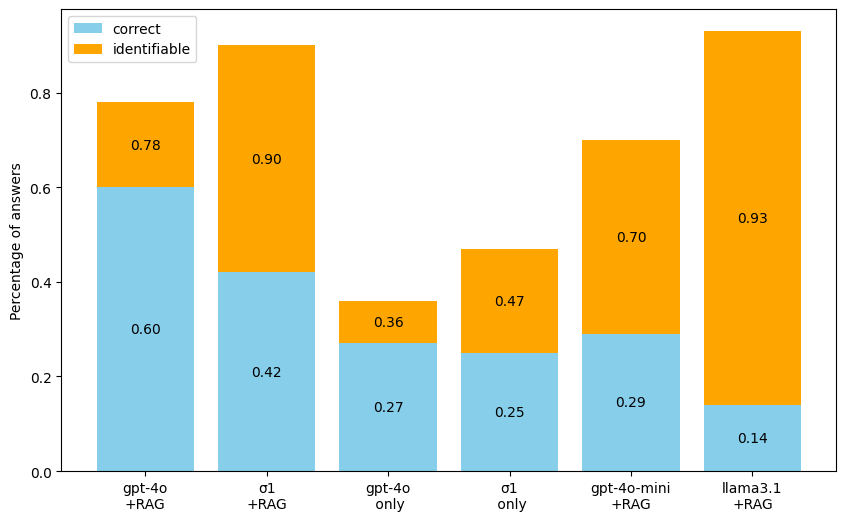

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Data for the bar chart
labels = ['gpt-4o\n+RAG','σ1\n+RAG','gpt-4o\n only','σ1\n only', 'gpt-4o-mini\n+RAG', 'llama3.1\n+RAG']
values_right = np.array([0.60, 0.42, 0.27, 0.25, 0.29, 0.14])
values_identifiable = np.array([0.78, 0.90, 0.36, 0.47, 0.70, 0.93])

# Creating a DataFrame for easier manipulation
data = pd.DataFrame({
    'Model': labels,
    'Right': values_right,
    'Identifiable': values_identifiable - values_right
})

# Setting up the plot
plt.figure(figsize=(10, 6))
bottom_values = np.zeros(len(labels))  # To keep track of where the bars should start

# Plotting the 'Right' values
bars1 = plt.bar(labels, values_right, color='skyblue', label='correct')

# Plotting the 'Identifiable' values on top of the 'Right' values
bars2 = plt.bar(labels, values_identifiable - values_right, bottom=values_right, color='orange', label='identifiable')

# Adding the values on top of the bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height/2, f'{height:.2f}', ha='center', va='center', color='black', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_y() + height/2, f'{bar.get_y() + height:.2f}', ha='center', va='center', color='black', fontsize=10)

# Adding chart title and labels
#plt.title('Comparison of Different Model Answers')
#plt.xlabel('Model')
plt.ylabel('Percentage of answers')
plt.legend()

# Displaying the chart
plt.show()


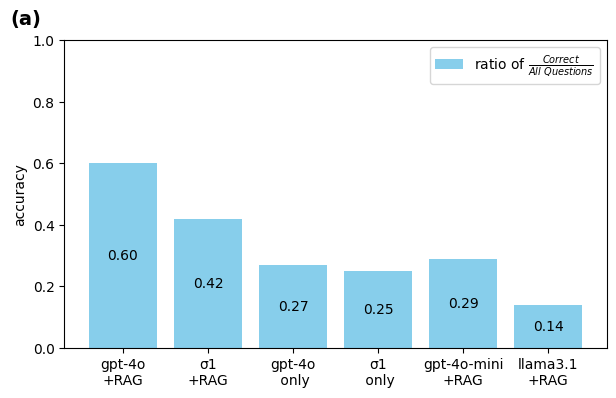

In [69]:
plt.figure(figsize=(7, 4))
bottom_values = np.zeros(len(labels))  # To keep track of where the bars should start

# Plotting the 'Right' values
bars1 = plt.bar(labels, values_right, color='skyblue')

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height/2, f'{height:.2f}', ha='center', va='center', color='black', fontsize=10)

plt.text(-0.1, 1.05, '(a)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')

plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(labels=[r"ratio of $\frac{Correct}{All\ Questions}$"])

#plt.legend()

# Displaying the chart
plt.savefig("RAG_Accuracy.svg", format="svg", bbox_inches='tight')
plt.show()


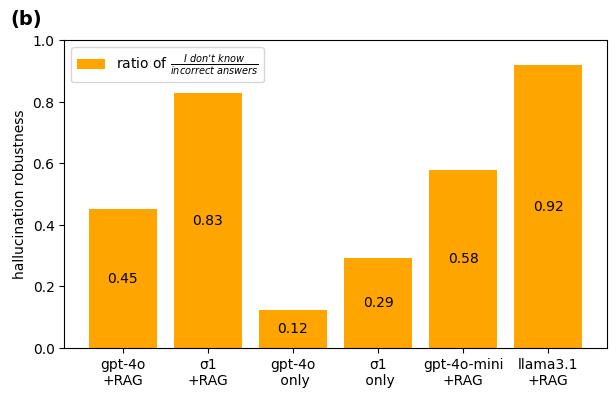

In [68]:
plt.figure(figsize=(7, 4))
bottom_values = np.zeros(len(labels))  # To keep track of where the bars should start

# Plotting the 'Right' values
bars2 = plt.bar(labels, (values_identifiable-values_right)/(1-values_right),  color='orange', label='I don’t know / non-correct answer')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_y() + height/2, f'{bar.get_y() + height:.2f}', ha='center', va='center', color='black', fontsize=10)

plt.text(-0.1, 1.05, '(b)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold')


plt.ylabel('hallucination robustness')
plt.ylim(0,1)
plt.legend(labels=[r"ratio of $\frac{I\ don’t\ know }{incorrect\ answers}$"])

# Displaying the chart
plt.savefig("RAG_HallucinatioRobustness.svg", format="svg", bbox_inches='tight')
plt.show()
